<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#load-data" data-toc-modified-id="load-data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>load data</a></span></li><li><span><a href="#EDA" data-toc-modified-id="EDA-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>EDA</a></span></li><li><span><a href="#Outlier-Process" data-toc-modified-id="Outlier-Process-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Outlier Process</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#load-distribution" data-toc-modified-id="load-distribution-3.0.1"><span class="toc-item-num">3.0.1&nbsp;&nbsp;</span>load distribution</a></span></li><li><span><a href="#zero-load-time-distribution" data-toc-modified-id="zero-load-time-distribution-3.0.2"><span class="toc-item-num">3.0.2&nbsp;&nbsp;</span>zero load time distribution</a></span></li></ul></li></ul></li><li><span><a href="#check-outlier-sample" data-toc-modified-id="check-outlier-sample-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>check outlier sample</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Note" data-toc-modified-id="Note-4.0.1"><span class="toc-item-num">4.0.1&nbsp;&nbsp;</span>Note</a></span></li></ul></li></ul></li><li><span><a href="#Missing-Process" data-toc-modified-id="Missing-Process-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Missing Process</a></span></li><li><span><a href="#Baseline" data-toc-modified-id="Baseline-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Baseline</a></span></li><li><span><a href="#Boosting-Model" data-toc-modified-id="Boosting-Model-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Boosting Model</a></span></li><li><span><a href="#LSTM-/-GRU" data-toc-modified-id="LSTM-/-GRU-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>LSTM / GRU</a></span></li></ul></div>

In [9]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
import random
%matplotlib inline

## load data

In [10]:
#df = pd.read_csv('./负荷预测/C.test_data201803.csv', parse_dates=['time']).iloc[:, 1:]
df = pd.read_csv('./test_data201803.csv', parse_dates=['time']).iloc[:, 1:]
df.head()

,time,KWH
0,2006-01-02 00:59:00,0.00
1,2006-01-02 01:59:00,0.00
2,2006-01-02 02:59:00,0.00
3,2006-01-02 03:59:00,91.75
4,2006-01-02 04:59:00,68.50


In [11]:
ALL = pd.DataFrame({'time': pd.date_range(start=df.time.min(), end=df.time.max(), freq='h'), 'P': np.nan})
df = pd.merge(ALL, df, how='outer').loc[:, ['time', 'KWH']]

## EDA

In [76]:
#print(f'time interval: {df.time.min()} ~ {df.time.max()}')
#print(f'nan rate     : {df.KWH.isnull().mean()}')
print('time interval: %s ~ %s' % (df.time.min(), df.time.max()))
print('NaN rate: %f%%' % (df.KWH.isnull().mean()*100.0))
df.groupby(df.time.dt.month)['KWH'].apply(lambda x: len(x))

time interval: 2006-01-02 00:59:00 ~ 2006-12-31 23:59:00
NaN rate: 0.000000%


time
1     720
2     672
3     744
4     720
5     744
6     720
7     744
8     744
9     720
10    744
11    720
12    744
Name: KWH, dtype: int64

In [17]:
df.groupby(df.time.dt.month)['KWH'].apply(lambda x: x.isnull().mean())

time
1     0.000000
2     0.035714
3     0.129032
4     0.000000
5     0.064516
6     0.000000
7     0.000000
8     0.000000
9     0.000000
10    0.000000
11    0.033333
12    0.000000
Name: KWH, dtype: float64

**Note**
12月份数据无缺失，做为测试集

In [18]:
df.describe()

,KWH
count,8544.000000
mean,3366.880501
std,1155.144517
min,0.000000
25%,3352.500000
50%,3610.000000
75%,3802.500000
max,4900.000000


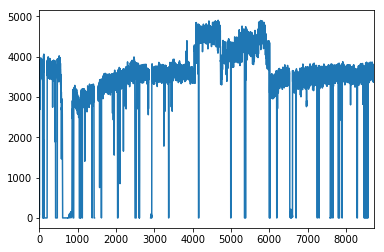

In [19]:
df.KWH.plot()

## Outlier Process

#### load distribution

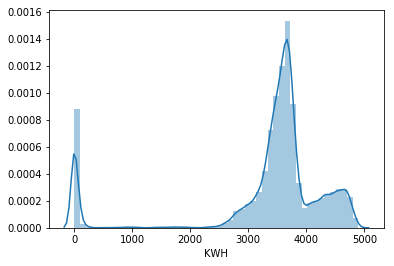

In [20]:
sns.distplot(df.KWH.dropna())

#### zero load time distribution

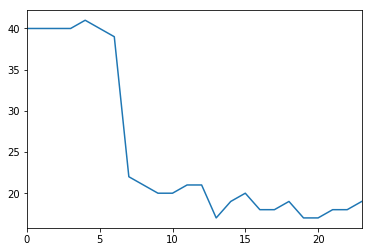

In [21]:
df[df.KWH == 0]['time'].dt.hour.value_counts().sort_index().plot()

## check outlier sample

In [52]:
zero_load_day = np.unique(df[df.KWH==0]['time'].dt.date)
def random_plot():
    date = random.choice(zero_load_day)
    df_sample = df[df.time.dt.date == date]['KWH']
    print('Random chosen date: %s' % date)
    #plt.plot(df[df.time.dt.date == date]['KWH'])
    df_sample.plot()

Random chosen date: 2006-02-28


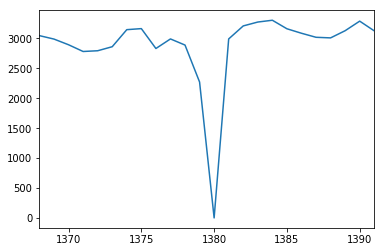

In [56]:
random_plot()

Random chosen date: 2006-09-09


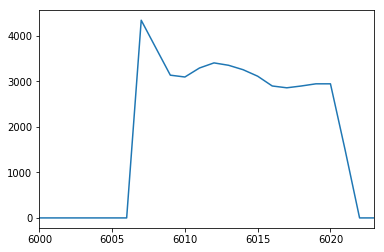

In [57]:
random_plot()

Random chosen date: 2006-02-07


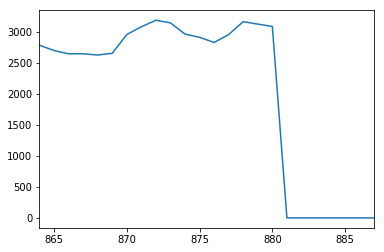

In [58]:
random_plot()

#### Note
不能肯定0负荷是异常

## Missing Process

In [59]:
df = df.interpolate()

## Baseline

+ 用上一小时数据预测下一小时
+ 数据划分：1～11月时间用于训练和调参，12月数据用于测试；
+ 评估指标：mae

In [60]:
def mape(t, p):
    return np.mean(np.abs(t-p) / t)

def baseline():
    target = df.iloc[-744:, -1].values
    pred = df.iloc[-745:-1, -1].values
    return mean_absolute_error(y_true=target, y_pred=pred)

In [61]:
baseline()

147.10685483870967

## Boosting Model

+ 数据划分：1～11月时间用于训练和调参，12月数据用于测试；
+ 评估指标：mae, mse

In [64]:
def get_lgb_data(lag=48, dropzero=True):
    lag_df = pd.DataFrame()
    for i in range(1, lag):
        #lag_df[f'lag_{i}'] = df['KWH'].shift(i)
        lag_df[('lag_{%s}' % str(i))] = df['KWH'].shift(i)
    date_df = pd.DataFrame()
    date_df['hour'] = df.time.dt.hour
    date_df['weekday'] = df.time.dt.weekday
    date_df['season'] = df.time.dt.quarter
    feat_df = pd.concat([lag_df, date_df], axis=1)
    
    train_x = feat_df.iloc[lag:-744]
    train_y = df.KWH.iloc[lag:-744]
    test_x = feat_df.iloc[-744:]
    test_y = df.KWH.iloc[-744:]
    
    if dropzero:
        train_zero = np.where(train_y!=0)[0]
        test_zero = np.where(test_y!=0)[0]
        train_x, train_y = train_x.iloc[train_zero], train_y.iloc[train_zero]
        test_x, test_y = test_x.iloc[test_zero], test_y.iloc[test_zero]
    
    return train_x, train_y, test_x, test_y

train_x, train_y, test_x, test_y = get_lgb_data()

采用bagging ensemble做为模型融合

In [67]:
param = {
    'objective': 'regression',
    'metric': 'mae',
    'learning_rate': 0.008,
}

num_trees = 1000
seed = 2019
k = 5
oof = np.zeros_like(train_y)
prediction = np.zeros_like(test_y)

kfolds = KFold(n_splits=k, random_state=seed, shuffle=False)

print('Start trainning ...')
for fk, (trn_idx, val_idx) in enumerate(kfolds.split(train_x.values, train_y.values)):
    print('fold {%d}' % fk)
    trn_data = lgb.Dataset(train_x.iloc[trn_idx], label=train_y.iloc[trn_idx])
    val_data = lgb.Dataset(train_x.iloc[val_idx], label=train_y.iloc[val_idx])
    model = lgb.train(param, trn_data, num_trees, valid_sets=[trn_data, val_data], verbose_eval=200, early_stopping_rounds=30)
    oof[val_idx] = model.predict(train_x.iloc[val_idx], num_iteration=model.best_iteration)
    prediction += model.predict(test_x, num_iteration=model.best_iteration) / k

cv_mae = mean_absolute_error(y_pred=oof, y_true=train_y)
test_mae = mean_absolute_error(y_pred=prediction, y_true=test_y)
test_mape = mape(test_y, prediction)
print('CV mae {%f}' % cv_mae)
print('test mae {%f}' % test_mae )
print('test mape {%f}' % test_mape)
#print(f'test mape {test_mape}')

Start trainning ...
fold {0}
Training until validation scores don't improve for 30 rounds.
[200]	training's l1: 119.472	valid_1's l1: 270.015
[400]	training's l1: 69.556	valid_1's l1: 167.674
[600]	training's l1: 59.5702	valid_1's l1: 151.002
Early stopping, best iteration is:
[606]	training's l1: 59.417	valid_1's l1: 150.928
fold {1}
Training until validation scores don't improve for 30 rounds.
[200]	training's l1: 144.328	valid_1's l1: 115.051
[400]	training's l1: 76.0583	valid_1's l1: 92.6188
Early stopping, best iteration is:
[431]	training's l1: 72.6143	valid_1's l1: 91.8778
fold {2}
Training until validation scores don't improve for 30 rounds.
[200]	training's l1: 139.213	valid_1's l1: 175.965
[400]	training's l1: 78.5813	valid_1's l1: 90.3074
[600]	training's l1: 66.4488	valid_1's l1: 79.9959
[800]	training's l1: 60.7461	valid_1's l1: 77.86
[1000]	training's l1: 56.8106	valid_1's l1: 77.1921
Did not meet early stopping. Best iteration is:
[1000]	training's l1: 56.8106	valid_1's 

In [69]:
mean_squared_error(test_y, prediction)
## Previous result: 31271.64596211783

31271.64596211783

In [70]:
train_x, train_y, test_x, test_y = get_lgb_data(dropzero=False)

In [71]:
param = {
    'objective': 'regression',
    'metric': 'mse',
    'learning_rate': 0.01,
}

num_trees = 1000
seed = 2019
k = 5
oof = np.zeros_like(train_y)
prediction = np.zeros_like(test_y)

kfolds = KFold(n_splits=k, random_state=seed, shuffle=False)

print('Start trainning ...')
for fk, (trn_idx, val_idx) in enumerate(kfolds.split(train_x.values, train_y.values)):
    #print(f'fold {fk}')
    print('fold {%d}' % fk)
    trn_data = lgb.Dataset(train_x.iloc[trn_idx], label=train_y.iloc[trn_idx])
    val_data = lgb.Dataset(train_x.iloc[val_idx], label=train_y.iloc[val_idx])
    model = lgb.train(param, trn_data, num_trees, valid_sets=[trn_data, val_data], verbose_eval=200, early_stopping_rounds=30)
    oof[val_idx] = model.predict(train_x.iloc[val_idx], num_iteration=model.best_iteration)
    prediction += model.predict(test_x, num_iteration=model.best_iteration) / k

cv_mae = mean_absolute_error(y_pred=oof, y_true=train_y)
test_mae = mean_absolute_error(y_pred=prediction, y_true=test_y)
test_mape = mape(test_y, prediction)
#print(f'CV mae {cv_mae}')
#print(f'test mae {test_mae}')
#print(f'test mape {test_mape}')
print('CV mae {%f}' % cv_mae)
print('test mae {%f}' % test_mae )
print('test mape {%f}' % test_mape)

Start trainning ...
fold {0}
Training until validation scores don't improve for 30 rounds.
[200]	training's l2: 72178.6	valid_1's l2: 319332
[400]	training's l2: 41573.7	valid_1's l2: 197980
Early stopping, best iteration is:
[447]	training's l2: 38557.3	valid_1's l2: 191905
fold {1}
Training until validation scores don't improve for 30 rounds.
[200]	training's l2: 100676	valid_1's l2: 93679.8
Early stopping, best iteration is:
[356]	training's l2: 57013.3	valid_1's l2: 83215.7
fold {2}
Training until validation scores don't improve for 30 rounds.
[200]	training's l2: 104172	valid_1's l2: 85909.9
[400]	training's l2: 56157.8	valid_1's l2: 59257.1
Early stopping, best iteration is:
[463]	training's l2: 51931.8	valid_1's l2: 58799.1
fold {3}
Training until validation scores don't improve for 30 rounds.
[200]	training's l2: 93029.2	valid_1's l2: 136766
Early stopping, best iteration is:
[337]	training's l2: 54423.4	valid_1's l2: 125606
fold {4}
Training until validation scores don't impro

In [75]:
pred_mse = mean_squared_error(test_y, prediction)
#Previous result: 120816.07875201685
print('Mean-squared-error: %f' % pred_mse)
print('L2-error: %f' % np.sqrt(pred_mse))

Mean-squared-error: 120816.078752
L2-error: 347.586074



## LSTM / GRU

In [73]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam, SGD
from torch.utils.data import Dataset, DataLoader

import ignite
from ignite.engine import create_supervised_evaluator, create_supervised_trainer, Engine, Events, State
from ignite.handlers import EarlyStopping
from ignite.metrics import MeanSquaredError, MeanAbsoluteError

ImportError: No module named ignite

In [261]:
def get_gru_data(seq_lens=48, dropzero=True):
    feat = pd.DataFrame()
    for i in range(1, seq_lens+1):
        feat[f'lag_{i}'] = df.KWH.shift(i)
    train_x = feat.iloc[seq_lens:-744]
    train_y = df.KWH.iloc[seq_lens:-744]
    test_x = feat.iloc[-744:]
    test_y = df.KWH.iloc[-744:]
    if dropzero:
        train_zero = np.where(train_y!=0)[0]
        test_zero = np.where(test_y!=0)[0]
        train_x, train_y = train_x.iloc[train_zero], train_y.iloc[train_zero]
        test_x, test_y = test_x.iloc[test_zero], test_y.iloc[test_zero]
    return train_x.values, train_y, test_x.values, test_y

train_x, train_y, test_x, test_y = get_gru_data()



x_scaler = StandardScaler().fit(train_x)
y_scaler = StandardScaler().fit(train_y)

/Users/zhouzhirui/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:586: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


In [298]:
class SeqsDataset(Dataset):
    
    def __init__(self, x, y):
        self.x = torch.tensor(x)
        self.y = torch.tensor(y)
    def __len__(self):
        return len(self.x)
    def __getitem__(self, item):
        return (self.x[item], self.y[item])

In [337]:
class Net(nn.Module):

    def __init__(self, input_size, hidden_size, num_layers=3, dropout_ratio=0.1):

        super().__init__()
        assert num_layers >= 1
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.dropout_ratio = dropout_ratio
        
        self.blocks = nn.ModuleList()
        self.blocks.append(self.add_fc_block(input_size, hidden_size, 0))
        for i in range(1, num_layers):
            self.blocks.append(self.add_fc_block(hidden_size, hidden_size//2, i))
            hidden_size //= 2
        self.blocks.append(nn.Linear(hidden_size, 1))

    def add_fc_block(self, input_size, hidden_size, layer_id):
        block = Sequential(OrderedDict([
            (f'fc_{layer_id}', nn.Linear(input_size, hidden_size)),
            (f'bn_{layer_id}', nn.BatchNorm1d(hidden_size)),
            (f'relu_{layer_id}', nn.ReLU()),
            (f'dropout_{layer_id}', nn.Dropout(self.dropout_ratio))
        ]))
        return block

    def forward(self, x):
        for block in self.blocks:
            x = block(x)
        outputs = F.logsigmoid(x)
        return outputs